In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

In [4]:
expr = pd.read_csv('CAFs.txt', sep='\t')
print(expr)

               SS2_15_0048_A3  SS2_15_0048_A6  ...  SS2_15_0049_P22  SS2_15_0049_P24
0610005C13Rik               0               0  ...                0                0
0610007P14Rik               0               0  ...               15                0
0610009B22Rik               0               0  ...                5                0
0610009L18Rik               0               0  ...                0                0
0610009O20Rik               0               0  ...               10                0
...                       ...             ...  ...              ...              ...
ERCC-00164                  0               0  ...                0                0
ERCC-00165                  8              23  ...               43                0
ERCC-00168                  0               0  ...                0                0
ERCC-00170                  0              20  ...                0                0
ERCC-00171                652             612  ...              2

In [0]:
X_train = expr.values[:,0:(expr.shape[1]-1)]
X_train = np.log(X_train + 1)

X_train = X_train[:716, :557]

In [6]:
n = X_train.shape[0]
print("\nThis data set contains " + str(n) + " samples")
y_train = expr.values[:716:,expr.shape[1]-1]
print("\nDimensions of the  data set: ")
print(X_train.shape, y_train.shape)


This data set contains 716 samples

Dimensions of the  data set: 
(716, 557) (716,)


In [26]:
dist = np.square(euclidean_distances(X_train, X_train))
rho = [sorted(dist[i])[1] for i in range(dist.shape[0])]
print(dist[0:4, 0:4])
print('\n')
print(rho[0:4])

[[   0.         1859.30737474 1239.67644955  223.24962365]
 [1859.30737474    0.         1883.03173818 1799.39133529]
 [1239.67644955 1883.03173818    0.         1226.49713613]
 [ 223.24962365 1799.39133529 1226.49713613    0.        ]]


[4.827978113663358, 1340.0015329089906, 1155.4805071305254, 209.89747465133752]


In [27]:
def prob_high_dim(sigma, dist_row):
    """
    For each row of Euclidean distance matrix (dist_row) compute
    probability in high dimensions (1D array)
    """
    d = dist[dist_row] - rho[dist_row]
    d[d < 0] = 0
    return np.exp(- d / sigma)

def k(prob):
    """
    Compute n_neighbor = k (scalar) for each 1D array of high-dimensional probability
    """
    return np.power(2, np.sum(prob))

def sigma_binary_search(k_of_sigma, fixed_k):
    """
    Solve equation k_of_sigma(sigma) = fixed_k 
    with respect to sigma by the binary search algorithm
    """
    sigma_lower_limit = 0
    sigma_upper_limit = 1000
    for i in range(20):
        approx_sigma = (sigma_lower_limit + sigma_upper_limit) / 2
        if k_of_sigma(approx_sigma) < fixed_k:
            sigma_lower_limit = approx_sigma
        else:
            sigma_upper_limit = approx_sigma
        if np.abs(fixed_k - k_of_sigma(approx_sigma)) <= 1e-5:
            break
    return approx_sigma

N_NEIGHBOR = 15
prob = np.zeros((n,n))
sigma_array = []
for dist_row in range(n):
    func = lambda sigma: k(prob_high_dim(sigma, dist_row))
    binary_search_result = sigma_binary_search(func, N_NEIGHBOR)
    prob[dist_row] = prob_high_dim(binary_search_result, dist_row)
    sigma_array.append(binary_search_result)
    if (dist_row + 1) % 100 == 0:
        print("Sigma binary search finished {0} of {1} cells".format(dist_row + 1, n))
print("\nMean sigma = " + str(np.mean(sigma_array)))

Sigma binary search finished 100 of 716 cells
Sigma binary search finished 200 of 716 cells
Sigma binary search finished 300 of 716 cells
Sigma binary search finished 400 of 716 cells
Sigma binary search finished 500 of 716 cells
Sigma binary search finished 600 of 716 cells
Sigma binary search finished 700 of 716 cells

Mean sigma = 10.636833126984495


In [0]:
#P = prob + np.transpose(prob) - np.multiply(prob, np.transpose(prob))
P = (prob + np.transpose(prob)) / 2

In [0]:
from scipy import optimize, special

In [31]:
MIN_DIST = 0.25

x = np.linspace(0, 3, 300)

def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

Hyperparameters a = 1.121436342369708 and b = 1.057499876613678


In [0]:
a = 1
b = 1

In [0]:
def prob_low_dim(Y):
    """
    Compute matrix of probabilities q_ij in low-dimensional space
    """
    inv_distances = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    return inv_distances
def CE(P, Y):
    """
    Compute Cross-Entropy (CE) from matrix of high-dimensional probabilities 
    and coordinates of low-dimensional embeddings
    """
    Q = prob_low_dim(Y)
    return - P * np.log(Q + 0.01) - (1 - P) * np.log(1 - Q + 0.01)

def CE_gradient(P, Y):
    """
    Compute the gradient of Cross-Entropy (CE)
    """
    y_diff = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    inv_dist = np.power(1 + a * np.square(euclidean_distances(Y, Y))**b, -1)
    Q = np.dot(1 - P, np.power(0.001 + np.square(euclidean_distances(Y, Y)), -1))
    np.fill_diagonal(Q, 0)
    Q = Q / np.sum(Q, axis = 1, keepdims = True)
    fact = np.expand_dims(a * P * (1e-8 + np.square(euclidean_distances(Y, Y)))**(b-1) - Q, 2)
    return 2 * b * np.sum(fact * y_diff * np.expand_dims(inv_dist, 2), axis = 1)

In [0]:
from sklearn.manifold import SpectralEmbedding

In [36]:
N_LOW_DIMS = 2
LEARNING_RATE = 1
MAX_ITER = 200

np.random.seed(12345)
model = SpectralEmbedding(n_components = N_LOW_DIMS, n_neighbors = 50)
y = model.fit_transform(np.log(X_train + 1))
#y = np.random.normal(loc = 0, scale = 1, size = (n, N_LOW_DIMS))

CE_array = []
print("Running Gradient Descent: \n")
for i in range(MAX_ITER):
    y = y - LEARNING_RATE * CE_gradient(P, y)
    
    plt.figure(figsize=(20,15))
    plt.scatter(y[:,0], y[:,1], c = y_train.astype(int), cmap = 'tab10', s = 50)
    plt.title("UMAP on Cancer Associated Fibroblasts (CAFs): Programmed from Scratch", fontsize = 20)
    plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
    #plt.savefig('UMAP_Plots/UMAP_iter_' + str(i) + '.png')
    plt.close()
    
    CE_current = np.sum(CE(P, y)) / 1e+5
    CE_array.append(CE_current)
    if i % 10 == 0:
        print("Cross-Entropy = " + str(CE_current) + " after " + str(i) + " iterations")

Running Gradient Descent: 

Cross-Entropy = 9.853723802684215 after 0 iterations
Cross-Entropy = 6.224658168763434 after 10 iterations
Cross-Entropy = 5.970531247615803 after 20 iterations
Cross-Entropy = 5.408712911264084 after 30 iterations
Cross-Entropy = 5.675328913871133 after 40 iterations
Cross-Entropy = 5.669071434583925 after 50 iterations
Cross-Entropy = 5.273131886273797 after 60 iterations
Cross-Entropy = 5.912834599564492 after 70 iterations
Cross-Entropy = 5.689821255382867 after 80 iterations
Cross-Entropy = 5.881764076192856 after 90 iterations
Cross-Entropy = 5.483251868836235 after 100 iterations
Cross-Entropy = 5.4833701701730035 after 110 iterations
Cross-Entropy = 5.7494907547425935 after 120 iterations
Cross-Entropy = 5.7848434805699425 after 130 iterations
Cross-Entropy = 5.908464246390837 after 140 iterations
Cross-Entropy = 5.478253482296788 after 150 iterations
Cross-Entropy = 5.919225428721569 after 160 iterations
Cross-Entropy = 5.424573698654135 after 170 i

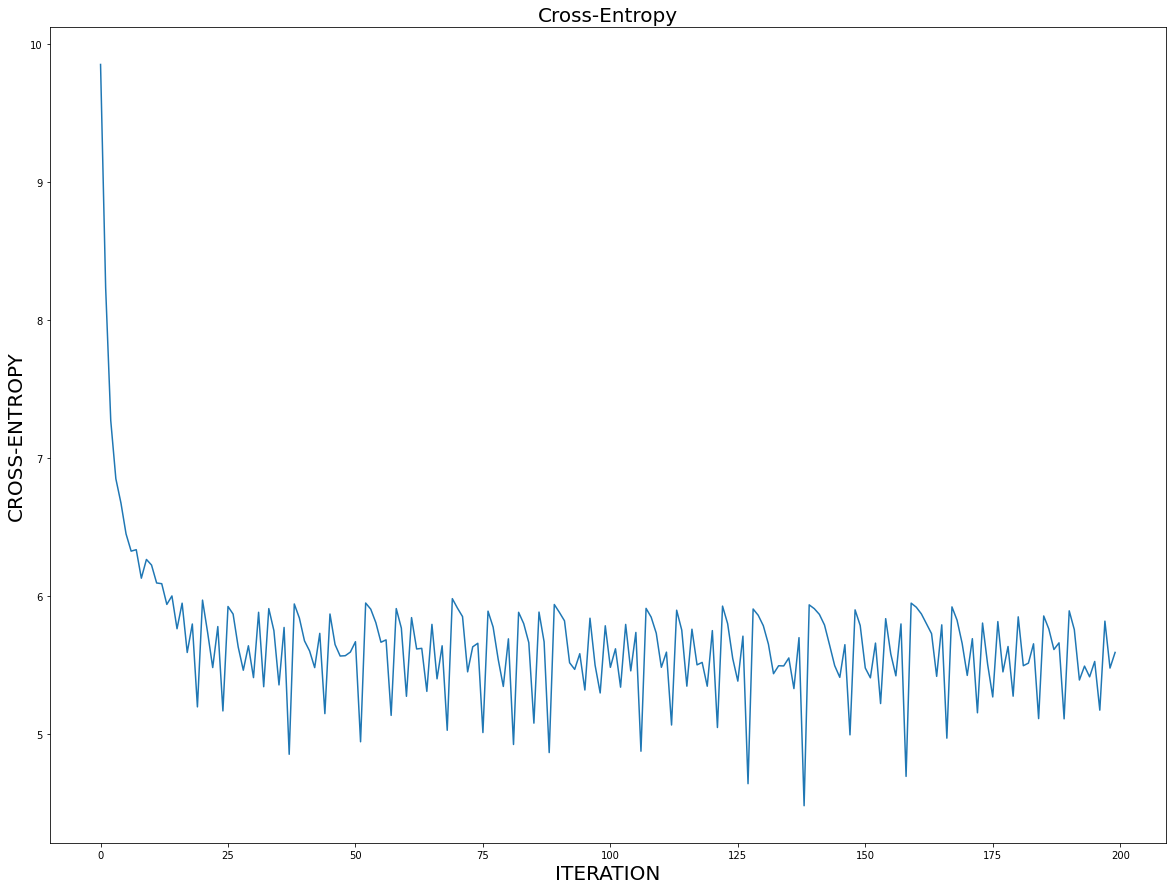

In [37]:
plt.figure(figsize=(20,15))
plt.plot(CE_array)
plt.title("Cross-Entropy", fontsize = 20)
plt.xlabel("ITERATION", fontsize = 20); plt.ylabel("CROSS-ENTROPY", fontsize = 20)
plt.show()

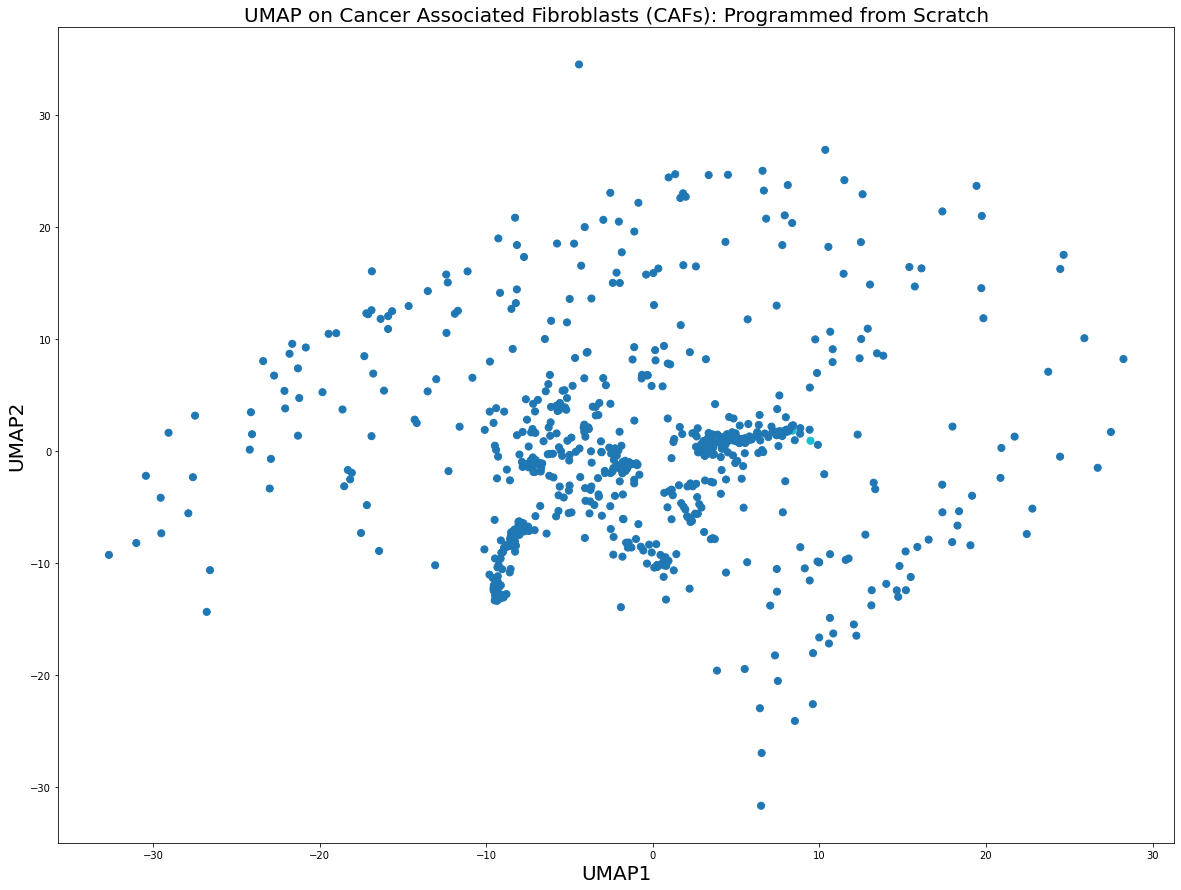

In [38]:
plt.figure(figsize=(20,15))
plt.scatter(y[:,0], y[:,1], c = y_train.astype(int), cmap = 'tab10', s = 50)
plt.title("UMAP on Cancer Associated Fibroblasts (CAFs): Programmed from Scratch", fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
plt.show()

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.25, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=True)
Construct fuzzy simplicial set
Wed May 13 15:19:59 2020 Finding Nearest Neighbors
Wed May 13 15:20:01 2020 Finished Nearest Neighbor Search
Wed May 13 15:20:02 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	complete

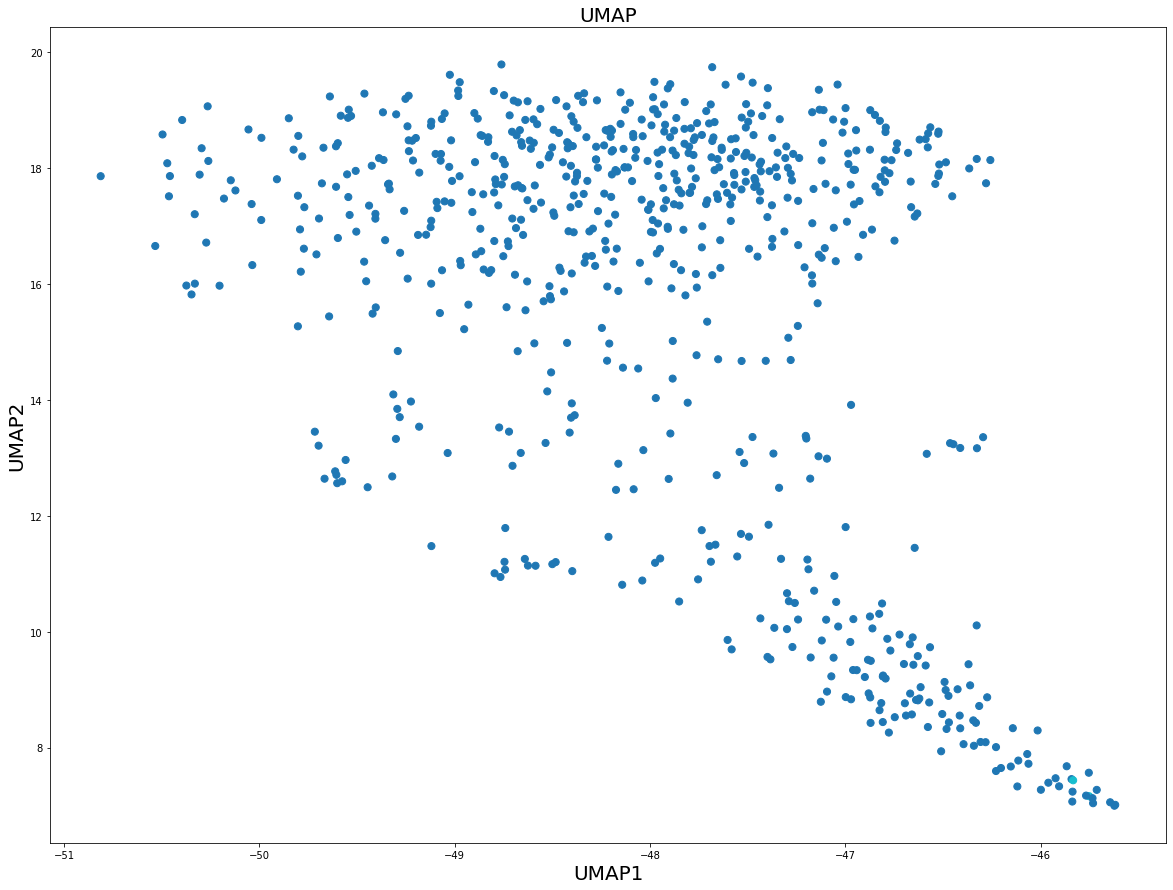

In [39]:
from umap import UMAP
plt.figure(figsize=(20,15))
model = UMAP(n_neighbors = 15, min_dist = 0.25, n_components = 2, verbose = True)
umap = model.fit_transform(X_train)
plt.scatter(umap[:, 0], umap[:, 1], c = y_train.astype(int), cmap = 'tab10', s = 50)
plt.title('UMAP', fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20)
plt.ylabel("UMAP2", fontsize = 20)
plt.show()